In [ ]:
# https://www.kaggle.com/pmigdal/alien-vs-predator-images

In [11]:
from tensorflow.keras.applications import Xception
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception

In [12]:
input_shape = (150, 150, 3)
target_size = (150, 150)

batch_size = 16

In [13]:
def visualize_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [14]:
def build_base_cnn_model():
    model = Sequential()
    model.add(Conv2D(input_shape=input_shape, filters=64, kernel_size=(4,4), strides=(2)))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(1)))
    model.add(MaxPooling2D(pool_size=4))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer = 'adam', 
        loss = 'binary_crossentropy', 
        metrics = ['accuracy']
    )
    return model

base_cnn_model = build_base_cnn_model()
base_cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 74, 74, 64)        3136      
_________________________________________________________________
activation_2 (Activation)    (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 71, 71, 64)        65600     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)              

In [15]:
train_samples = 694
test_samples = 200

training_steps = train_samples // batch_size
validation_steps = test_samples // batch_size


def get_train_test_generator():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255,
    )

    train_generator = train_datagen.flow_from_directory(
        "data/train",
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    validation_generator = test_datagen.flow_from_directory(
        "data/validation",
        batch_size=batch_size,
        target_size=target_size,
        class_mode='binary'
    )
    return train_generator, validation_generator

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/10
43/43 [==============================] - 38s 872ms/step - loss: 0.8359 - accuracy: 0.6136 - val_loss: 1.0708 - val_accuracy: 0.5469
Epoch 2/10
43/43 [==============================] - 36s 847ms/step - loss: 0.5879 - accuracy: 0.7109 - val_loss: 0.6599 - val_accuracy: 0.6719
Epoch 3/10
43/43 [==============================] - 38s 882ms/step - loss: 0.5729 - accuracy: 0.6785 - val_loss: 2.0083 - val_accuracy: 0.5104
Epoch 4/10
43/43 [==============================] - 37s 856ms/step - loss: 0.5274 - accuracy: 0.7493 - val_loss: 0.7767 - val_accuracy: 0.5990
Epoch 5/10
43/43 [==============================] - 37s 871ms/step - loss: 0.4872 - accuracy: 0.7529 - val_loss: 0.6125 - val_accuracy: 0.6406
Epoch 6/10
43/43 [==============================] - 36s 840ms/step - loss: 0.4932 - accuracy: 0.7784 - val_loss: 0.5779 - val_accuracy: 0.6719
Epoch 7/10
43/43 [==============================] - 37s 851m

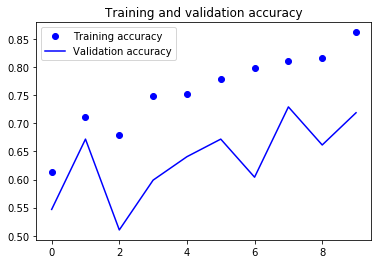

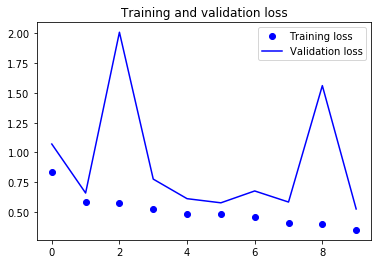

In [16]:
train_generator, validation_generator = get_train_test_generator()

history_base_cnn = base_cnn_model.fit_generator(
    train_generator,  
    steps_per_epoch=train_samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=test_samples // batch_size
)

base_cnn_model.save("base_cnn_model.h5")
visualize_history(history_base_cnn)

# Data Augmentation

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/10
43/43 [==============================] - 40s 931ms/step - loss: 0.7242 - accuracy: 0.6106 - val_loss: 1.0569 - val_accuracy: 0.5469
Epoch 2/10
43/43 [==============================] - 38s 887ms/step - loss: 0.5782 - accuracy: 0.7183 - val_loss: 1.0197 - val_accuracy: 0.5156
Epoch 3/10
43/43 [==============================] - 38s 887ms/step - loss: 0.5809 - accuracy: 0.6873 - val_loss: 0.6452 - val_accuracy: 0.6719
Epoch 4/10
43/43 [==============================] - 37s 869ms/step - loss: 0.5490 - accuracy: 0.7094 - val_loss: 1.2050 - val_accuracy: 0.5521
Epoch 5/10
43/43 [==============================] - 37s 851ms/step - loss: 0.5979 - accuracy: 0.6932 - val_loss: 0.9214 - val_accuracy: 0.6406
Epoch 6/10
43/43 [==============================] - 37s 854ms/step - loss: 0.5534 - accuracy: 0.7257 - val_loss: 0.6319 - val_accuracy: 0.6667
Epoch 7/10
43/43 [==============================] - 37s 852m

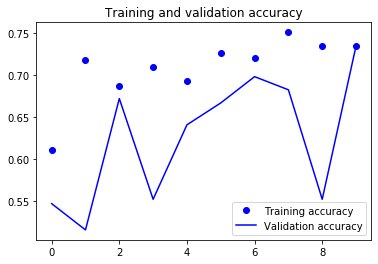

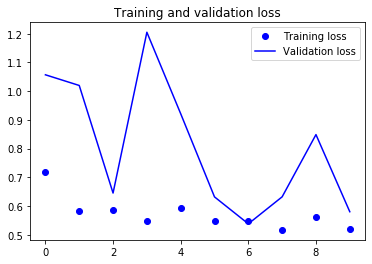

In [17]:
def get_augmented_train_test_generator():
        
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=10,
        zoom_range=0.2,
        horizontal_flip=True,
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255,
    )

    train_generator = train_datagen.flow_from_directory(
        "data/train",
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    validation_generator = test_datagen.flow_from_directory(
        "data/validation",
        batch_size=batch_size,
        target_size=target_size,
        class_mode='binary'
    )
    return train_generator, validation_generator


train_generator, validation_generator = get_augmented_train_test_generator()
base_cnn_model_with_augmentation = build_base_cnn_model()

history_base_augmented_cnn = base_cnn_model_with_augmentation.fit_generator(
    train_generator,
    steps_per_epoch=training_steps,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


base_cnn_model_with_augmentation.save("base_cnn_model_with_augmentation.h5")
visualize_history(history_base_augmented_cnn)

# Transfer Learning

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/15
43/43 [==============================] - 215s 5s/step - loss: 0.6423 - accuracy: 0.6490 - val_loss: 0.5516 - val_accuracy: 0.6927
Epoch 2/15
43/43 [==============================] - 217s 5s/step - loss: 0.5353 - accuracy: 0.7802 - val_loss: 0.3882 - val_accuracy: 0.8333
Epoch 3/15
43/43 [==============================] - 207s 5s/step - loss: 0.5016 - accuracy: 0.7573 - val_loss: 0.3573 - val_accuracy: 0.8333
Epoch 4/15
43/43 [==============================] - 202s 5s/step - loss: 0.4612 - accuracy: 0.8219 - val_loss: 0.4384 - val_accuracy: 0.7969
Epoch 5/15
43/43 [==============================] - 207s 5s/step - loss: 0.4180 - accuracy: 0.8319 - val_loss: 0.4631 - val_accuracy: 0.7812
Epoch 6/15
43/43 [==============================] - 207s 5s/step - loss: 0.4197 - accuracy: 0.8285 - val_loss: 0.5477 - val_accuracy: 0.7552
Epoch 7/15
43/43 [==============================] - 201s 5s/step - loss:

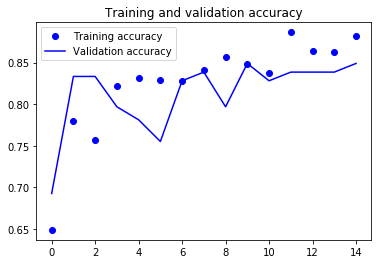

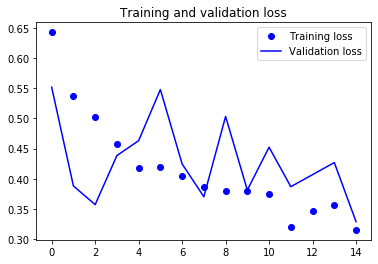

In [22]:
def create_xception_model():
    conv_base = Xception(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    for layer in conv_base.layers:
        layer.trainable = False

    xception = models.Sequential()
    xception.add(conv_base)
    xception.add(layers.GlobalAveragePooling2D())
    xception.add(layers.Dense(1, activation='sigmoid'))
    xception.compile(
        optimizer = 'adam', 
        loss = 'binary_crossentropy', 
        metrics = ['accuracy']
    )
    return xception


xception = create_xception_model()
train_generator, validation_generator = get_augmented_train_test_generator()

xception_history = xception.fit_generator(
    generator=train_generator,
    steps_per_epoch=training_steps,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

xception.save("xception.h5")
visualize_history(xception_history)

## Fine Tuning

Epoch 1/10
10/10 [==============================] - 54s 5s/step - loss: 0.6944 - accuracy: 0.5667 - val_loss: 0.6844 - val_accuracy: 0.5813
Epoch 2/10
10/10 [==============================] - 56s 6s/step - loss: 0.6716 - accuracy: 0.5750 - val_loss: 0.6985 - val_accuracy: 0.5437
Epoch 3/10
10/10 [==============================] - 56s 6s/step - loss: 0.6463 - accuracy: 0.6438 - val_loss: 0.5706 - val_accuracy: 0.7000
Epoch 4/10
10/10 [==============================] - 56s 6s/step - loss: 0.5810 - accuracy: 0.7688 - val_loss: 0.5393 - val_accuracy: 0.7250
Epoch 5/10
10/10 [==============================] - 54s 5s/step - loss: 0.5751 - accuracy: 0.7467 - val_loss: 0.5705 - val_accuracy: 0.6438
Epoch 6/10
10/10 [==============================] - 56s 6s/step - loss: 0.5359 - accuracy: 0.7750 - val_loss: 0.6476 - val_accuracy: 0.6187
Epoch 7/10
10/10 [==============================] - 56s 6s/step - loss: 0.5546 - accuracy: 0.7312 - val_loss: 0.5004 - val_accuracy: 0.7125
Epoch 8/10
10/10 [==

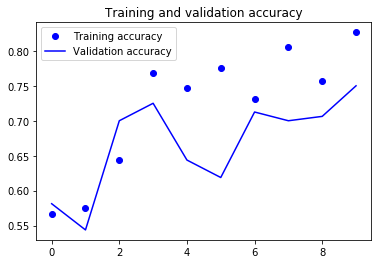

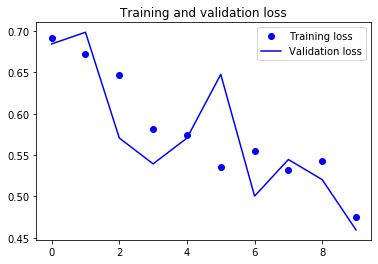

In [23]:
conv_base = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

for layer in conv_base.layers[:-5]:
    layer.trainable = False

xception_fine_tuning = create_xception_model()

xception_fine_tuning_history = xception_fine_tuning.fit_generator(
    generator=train_generator,
    steps_per_epoch=training_steps,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

xception_fine_tuning.save("xception_fine_tuning.h5")
visualize_history(xception_fine_tuning_history)